<a href="https://colab.research.google.com/github/amoukrim/AI/blob/main/Week8/DailyChallenge/dailyChallengew_8_d5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##@Author : Adil MOUKRIM

Building an agent with LangGraph
Last Updated: March 28th, 2025

## Daily Challenge : Building an agent with LangGraph and the Gemini API


👩‍🏫 👩🏿‍🏫 What You’ll learn
How to create a stateful application using LangGraph.
How to integrate Gemini API (via LangChain) into your LangGraph application.
How to define and manipulate state using TypedDict and node functions.
How to simulate dynamic, tool-augmented behavior (like menus and ordering) in a conversational loop.
How to model conditional transitions, loops, and user interaction using LangGraph.


🛠️ What you will create
A conversational cafe ordering system called BaristaBot. This bot will:

Use natural language to take coffee/tea orders.
Offer a real-time menu using a tool.
Confirm and modify orders.
Loop through conversation until an order is placed.
Handle tool calls using LangGraph’s ToolNode mechanism.
This graph-based app will simulate a real-world cafe assistant using AI + state management.



Task
In this notebook, you will use LangGraph to define a stateful graph-based application built on top of the Gemini API.
You will build a simulated cafe ordering system, called BaristaBot. It will provide a looping chat interface to customers where they can order cafe beverages using natural language, and you will build nodes to represent the cafe’s live menu and the “back room” ordering system.
BaristaBot is used in other Gemini API demos, so if you are looking to explore something with a more minimal implementation, check out the BaristaBot function calling example that implements a similar system using only the Gemini API Python SDK and function calling.

1. Start by installing and importing the LangGraph SDK and LangChain support for the Gemini API %pip install -qU 'langgraph==0.2.45' 'langchain-google-genai==2.0.4'.



2. Set up your API key : The GOOGLE_API_KEY environment variable can be set to automatically configure the underlying API. This works for both the official Gemini Python SDK and for LangChain/LangGraph.

To run the following cell, your API key must be stored it in a Kaggle secret named GOOGLE_API_KEY.
If you don’t already have an API key, you can grab one from AI Studio. You can find detailed instructions in the docs.
To make the key available through Kaggle secrets, choose Secrets from the Add-ons menu and follow the instructions to add your key or enable it for this notebook.



import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY


LangGraph applications are built around a graph structure. As the developer, you define an application graph that models the state transitions for your application. Your app will define a state schema, and an instance of that schema is propagated through the graph.

Each node in the graph represents an action or step that can be taken. Nodes will make changes to the state in some way through code that you define. These changes can be the result of invoking an LLM, by calling an API, or executing any logic that the node defines.

Each edge in the graph represents a transition between states, defining the flow of the program. Edge transitions can be fixed, for example if you define a text-only chatbot where output is always displayed to a user, you may always transition from chatbot -> user. The transitions can also be conditional, allowing you to add branching (like an if-else statement) or looping (like for or while loops).



3. Define core instructions: State is a fundamental concept for a LangGraph app. A state object is passed between every node and transition in the app. Here you define a state object, OrderState, that holds the conversation history, a structured order, and a flag indicating if the customer has finished placing their order. For simplicity, the “structure” in this order is just a
list of strings, but this can be expanded to any Python data structure.

In Python, the LangGraph state object is a Python dictionary. You can provide a schema for this dictionary by defining it as a TypedDict.
Here you also define the system instruction that the Gemini model will use. You can capture tone and style here, as well as the playbook under which the chatbot should operate.



from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool
# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
BARISTABOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"


4. Define a single turn chatboot

To illustrate how LangGraph works, the following program defines a chatbot node that will execute a single turn in a chat conversation using the instructions supplied.

Each node in the graph operates on the state object. The state (a Python dictionary) is passed as a parameter into the node (a function) and the new state is returned. This can be restated as pseudo-code, where state = node(state).

Note: For the chatbot node, the state is updated by adding the new conversation message. The add_messages annotation on OrderState.messages indicates that messages are appended when returned from a node. Typically state is updated by replacement, but this annotation causes messages to behave differently.



from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

# Try using different models. The `pro` models perform the best, especially
# with tool-calling. The `flash` models are super fast, and are a good choice
# if you need to use the higher free-tier quota.
# Check out the features and quota differences here: https://ai.google.dev/pricing
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")


def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph_builder = ...

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node(...)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(...)

chat_graph = ...


5. Visualise the graph you just defined.



6. Now that the graph is defined, you can run it. It only has one node, and one transition into that node, so it will transition from start to chatbot, execute the chatbot node, and terminate.
Run the graph by calling invoke and passing an initial state object. In this case it begins with the user’s initial message.



from pprint import pprint

user_msg = ...
state = ...

# The state object contains lots of information. Uncomment the pprint lines to see it all.
# pprint(state)

# Note that the final state now has 2 messages. Our HumanMessage, and an additional AIMessage.
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")


7. You could execute this in a Python loop, but for simplicity, manually invoke one more conversational turn. This second invocation takes the state from the first call and appends another user message to elicit another response from the chatbot.



user_msg = ...

state["messages"].append(...)
state = chat_graph.invoke(...)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")


8. Add a human node : Instead of repeatedly running the “graph” in a Python loop, you can use LangGraph to loop between nodes.

The human node will display the last message from the LLM to the user, and then prompt them for their next input. Here this is done using standard Python print and input functions, but for a real cafe situation, you could render the chat to a display or audio, and accept input from a mic or on-screen keyboard.

The chatbot node function has also been updated to include the welcome message to start the conversation. Complete the following code :



from langchain_core.messages.ai import AIMessage


def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


# Start building a new graph.
graph_builder = ...

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node(...)
graph_builder.add_node(...)

# Start with the chatbot again.
graph_builder.add_edge(...)

# The chatbot will always go to the human next.
graph_builder.add_edge(...);


9. Before you can run this, note that if you added an edge from human back to chatbot, the graph will cycle forever as there is no exit condition. One way to break the cycle is to add a check for a human input like q or quit and use that to break the loop.

In LangGraph, this is achieved with a conditional edge. This is similar to a regular graph transition, except a custom function is called to determine which edge to traverse.

Conditional edge functions take the state as input, and return a string representing the name of the node to which it will transition. Complete this code:



from typing import Literal


def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return ...


graph_builder.add_conditional_edges(...)

chat_with_human_graph = ...

Image(chat_with_human_graph.get_graph().draw_mermaid_png())


10. Add a “live” menu. BaristaBot currently has no awareness of the available items at the cafe, so it will hallucinate a menu. One option would be to hard-code a menu into the system prompt. This would work well, but to simulate a system where the menu is more dynamic and could respond to fluctuating stock levels, you will put the menu into a custom tool.

There are two types of tools that this system will use. Stateless tools that can be run automatically, and stateful tools that modify the order. The “get current menu” tool is stateless, in that it does not make any changes to the live order, so it can be called automatically.

In a LangGraph app, you can annotate Python functions as tools by applying the @tools annotation.



from langchain_core.tools import tool


@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    # Note that this is just hard-coded text, but you could connect this to a live stock
    # database, or you could use Gemini's multi-modal capabilities and take live photos of
    # your cafe's chalk menu or the products on the counter and assmble them into an input.

    return """
    MENU:
    Coffee Drinks:
    Espresso
    Americano
    Cold Brew

    Coffee Drinks with Milk:
    Latte
    Cappuccino
    Cortado
    Macchiato
    Mocha
    Flat White

    Tea Drinks:
    English Breakfast Tea
    Green Tea
    Earl Grey

    Tea Drinks with Milk:
    Chai Latte
    Matcha Latte
    London Fog

    Other Drinks:
    Steamer
    Hot Chocolate
Modifiers:
    Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
    Espresso shots: Single, Double, Triple, Quadruple; default: Double
    Caffeine: Decaf, Regular; default: Regular
    Hot-Iced: Hot, Iced; Default: Hot
    Sweeteners (option to add one or more): vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener
    Special requests: any reasonable modification that does not involve items not on the menu, for example: 'extra hot', 'one pump', 'half caff', 'extra foam', etc.

    "dirty" means add a shot of espresso to a drink that doesn't usually have it, like "Dirty Chai Latte".
    "Regular milk" is the same as 'whole milk'.
    "Sweetened" means add some regular sugar, not a sweetener.

    Soy milk has run out of stock today, so soy is not available.
  """


Now add the new tool to the graph. The get_menu tool is wrapped in a ToolNode that handles calling the tool and passing the response as a message through the graph. The tools are also bound to the llm object so that the underlying model knows they exist. As you now have a different llm object to invoke, you need to update the chatbot node so that it is aware of the tools.



from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [get_menu]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: OrderState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"

def chatbot_with_tools(state: OrderState) -> OrderState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


graph_builder = StateGraph(OrderState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())



11. Handle orders. To build up an order during the chat conversation, you will need to update the state to track the order, and provide simple tools that update this state. These need to be explicit as the model should not directly have access to the apps internal state, or it risks being manipulated arbitrarily.

The ordering tools will be added as stubs in a separate node so that you can edit the state directly. Using the @tool annotation is still a handy way to define their schema, so the ordering tools below are implemented as empty Python functions.
Complete this code :



from collections.abc import Iterable
from random import randint

from langgraph.prebuilt import InjectedState
from langchain_core.messages.tool import ToolMessage

# These functions have no body; LangGraph does not allow @tools to update
# the conversation state, so you will implement a separate node to handle
# state updates. Using @tools is still very convenient for defining the tool
# schema, so empty functions have been defined that will be bound to the LLM
# but their implementation is deferred to the order_node.


@tool
def add_to_order(drink: str, modifiers: Iterable[str]) -> str:
    """Adds the specified drink to the customer's order, including any modifiers.

    Returns:
      The updated order in progress.
    """


@tool
def confirm_order() -> str:
    """Asks the customer if the order is correct.

    Returns:
      The user's free-text response.
    """


@tool
def get_order() -> str:
    """Returns the users order so far. One item per line."""@tool
def clear_order():
    """Removes all items from the user's order."""


@tool
def place_order() -> int:
    """Sends the order to the barista for fulfillment.

    Returns:
      The estimated number of minutes until the order is ready.
    """

def order_node(state: OrderState) -> OrderState:
    """The ordering node. This is where the order state is manipulated."""
    tool_msg = ...
    order = ...
    outbound_msgs = []
    order_placed = False

    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_to_order":

            # Each order item is just a string. This is where it assembled as "drink (modifiers, ...)".
            modifiers = ...
            modifier_str = ", ".join(modifiers) if modifiers else "no modifiers"

            order.append(f'{tool_call["args"]["drink"]} ({modifier_str})')
            response = "\n".join(order)

        elif tool_call["name"] == ...;

            # We could entrust the LLM to do order confirmation, but it is a good practice to
            # show the user the exact data that comprises their order so that what they confirm
            # precisely matches the order that goes to the kitchen - avoiding hallucination
            # or reality skew.

            # In a real scenario, this is where you would connect your POS screen to show the
            # order to the user.

            print("Your order:")
            if not order:
                print("  (no items)")

            for drink in order:
                print(f"  {drink}")

            response = input("Is this correct? ")

        elif tool_call["name"] == "get_order":

            response = "\n".join(order) if order else "(no order)"

        elif tool_call["name"] == "clear_order":

            order.clear()response = None

        elif tool_call["name"] == "place_order":

            order_text = "\n".join(order)
            print("Sending order to kitchen!")
            print(order_text)

            # TODO(you!): Implement cafe.
            order_placed = True
            response = randint(1, 5)  # ETA in minutes

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "order": order, "finished": order_placed}

def maybe_route_to_tools(state: OrderState) -> str:
    """Route between chat and tool nodes if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        # When an order is placed, exit the app. The system instruction indicates
        # that the chatbot should say thanks and goodbye at this point, so we can exit
        # cleanly.
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "ordering"

    else:
        return "human"


12. Now define the graph. The LLM needs to know about the tools too, so that it can invoke them. Here you set up 2 sets of tools corresponding to the nodes under which they operate: automated and ordering.



# Auto-tools will be invoked automatically by the ToolNode
auto_tools = [get_menu]
tool_node = ...

# Order-tools will be handled by the order node.
order_tools = [...]

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = ...


graph_builder = ...

# Nodes
graph_builder.add_node(...
graph_builder.add_node(...
graph_builder.add_node(...
graph_builder.add_node(...

# Chatbot -> {ordering, tools, human, END}
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human -> {chatbot, END}
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools (both kinds) always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("ordering", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_order_tools = ...

Image(graph_with_order_tools.get_graph().draw_mermaid_png())


Now run the complete ordering system graph.



# The default recursion limit for traversing nodes is 25 - setting it higher
# means you can try a more complex order with multiple steps and round-trips.
config = {"recursion_limit": 100}

state = graph_with_order_tools.invoke({"messages": []}, config)

# Things to try:
# - Order a drink!
# - Make a change to your order.
# - "Which teas are from England?"
# - Note that the graph should naturally exit after placing an order.

pprint(state)


Duration & Difficulty
Duration (approx)	Difficulty
2 hours	⭐⭐

#✅ ÉTAPE 1 : Installation des bibliothèques

In [33]:
# Cette commande installe LangGraph (version spécifique) et l'intégration LangChain pour Gemini API
%pip install -qU 'langgraph==0.2.45' 'langchain-google-genai==2.0.4'


#✅ ÉTAPE 2 : Configuration de la clé API:
**Explication :**
Cette étape sécurise l’accès à l’API Gemini. LangChain utilise automatiquement cette variable d’environnement (GOOGLE_API_KEY) pour authentifier les requêtes.

In [34]:
import os
#from kaggle_secrets import UserSecretsClient

# Récupère la clé API depuis les secrets de Kaggle
#GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

# Définit cette clé dans les variables d’environnement pour que l’API Gemini puisse l’utiliser
os.environ["GOOGLE_API_KEY"] ="xxxxxxxxxxxxxxxxxxxx"


##✅ Vérifie que tout fonctionne :

In [35]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph
from pprint import pprint

# Modèle Gemini (rapide)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

# Instructions système
BARISTABOT_SYSINT = (
    "system",
    "You are a BaristaBot, an interactive cafe ordering system. ..."
)
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

# Fonction chatbot simple
def chatbot(state):
    messages = [BARISTABOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(messages)]}

# Construction du graphe
graph_builder = StateGraph(dict)
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
chat_graph = graph_builder.compile()

# Test d'un tour de conversation
user_msg = HumanMessage(content="What hot drinks do you have?")
state = chat_graph.invoke({"messages": [user_msg], "order": [], "finished": False})

# Affichage du résultat
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")


AIMessage: We have a wide variety of hot drinks!  To help me narrow it down for you, what kind of flavour profile are you looking for?  Do you prefer something:

* **Coffee based?** (e.g., Espresso, Americano, Latte, Cappuccino, Mocha, Flat White)  We also have decaf options!
* **Tea based?** (e.g., Black tea, Green tea, Herbal tea - we have a selection of flavours)
* **Something else entirely?** (e.g., Hot chocolate, Chai latte)


Let me know your preference and I can give you a more detailed menu!



##🧭 Étape suivante : Étape 5 — Visualiser le graphe

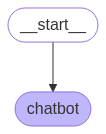

In [36]:
from IPython.display import Image

# Visualisation du graphe actuel
Image(chat_graph.get_graph().draw_mermaid_png())


Étape 6 — Nouvelle interaction (second tour de conversation)
Tu peux tester une deuxième interaction avec l’état actuel en ajoutant un nouveau message utilisateur :

In [37]:
from langchain_core.messages import HumanMessage

# Nouveau message utilisateur
user_msg2 = HumanMessage(content="I think I’d like something tea-based with milk.")

# On ajoute ce message à l'historique
state["messages"].append(user_msg2)

# Et on relance le graphe
state = chat_graph.invoke(state)

# Affichage des messages
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")


AIMessage: Excellent choice!  For tea-based drinks with milk, we offer:

* **Chai Latte:** A spiced black tea blend with milk and a touch of sweetness.  We can adjust the sweetness level to your preference.
* **Masala Chai Latte:** Similar to the Chai Latte, but with a more robust and complex blend of spices.
* **Black Tea Latte:** Your choice of black tea (English Breakfast, Earl Grey, etc.) steamed with milk.  We can also add sweetener if desired.
* **Green Tea Latte:** A lighter, more subtly flavored option with steamed milk.  Sweetener available upon request.


Would you like to hear more about any of these options, or do you have a preference already?  We also offer different types of milk (dairy, almond, soy, oat).  Which milk would you prefer?



# Interprétation :
Parfait 🙌 ! Le chatbot joue pleinement son rôle, en :

respectant la logique de commande (il te propose des options concrètes de latte à base de thé),

t’interrogeant sur les préférences (sucrant, taille, variété),

adoptant un ton professionnel et engageant, comme demandé dans l’instruction système.

Mais pour l’instant :

🤖 Le bot hallucine toujours le menu car il n’a pas encore accès au vrai menu via un outil.

##🧭 Étape suivante : Étape 8 – Ajouter un nœud "humain" + boucle de conversation

In [38]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class OrderState(TypedDict):
    """État de la commande pour BaristaBot."""
    messages: Annotated[list, add_messages]
    order: list[str]
    finished: bool


In [39]:
#✅ Code étape 8 – human_node + chatbot_with_welcome_msg

from langchain_core.messages.ai import AIMessage

def human_node(state: OrderState) -> OrderState:
    """Affiche le message de l’AI et récupère l’entrée utilisateur."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # Si l’utilisateur veut quitter, on met `finished = True`
    if user_input.lower() in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    # On retourne l’état avec le nouveau message utilisateur ajouté
    return state | {"messages": [("user", user_input)]}

def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """Chatbot qui affiche un message de bienvenue au démarrage."""
    if state["messages"]:
        # Conversation déjà entamée
        output = llm.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        # Premier message → on commence avec le message de bienvenue
        output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [output]}


In [40]:
from langgraph.graph import StateGraph, END
from typing import Literal

# 🧠 Fonction conditionnelle : si l'utilisateur tape 'q' ou 'quit', on quitte le graphe
def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

# 📈 Construction du graphe LangGraph
graph_builder = StateGraph(OrderState)

# Ajout des nœuds
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Transitions
graph_builder.add_edge("chatbot", "human")  # Après chaque réponse, on va vers humain
graph_builder.add_conditional_edges("human", maybe_exit_human_node)  # Si pas fini → chatbot

# Point d'entrée
graph_builder.set_entry_point("chatbot")

# Compilation du graphe
chat_with_human_graph = graph_builder.compile()


✅ Construction du graphe avec boucle de dialogue

In [41]:
graph_builder = StateGraph(OrderState)

# Ajout des nœuds
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Transition : chatbot → human
graph_builder.add_edge("chatbot", "human")

# Condition : human → chatbot OU END
from typing import Literal
from langgraph.graph import END

def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    if state.get("finished", False):
        return END  # Quitte le graphe
    else:
        return "chatbot"

graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Point d’entrée
graph_builder.set_entry_point("chatbot")

# Compilation
chat_with_human_graph = graph_builder.compile()


In [42]:
#✅ Lancer la conversation complète
# L'état initial vide (début de conversation)
initial_state = {
    "messages": [],
    "order": [],
    "finished": False
}

# Lancement : chatbot → human → boucle jusqu’à finished = True
chat_with_human_graph.invoke(initial_state)


Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?
User: TEA
Model: Great choice! What kind of tea would you like?  We have Black Tea, Green Tea, White Tea, Herbal Tea, and Chai.

User: Q


{'messages': [AIMessage(content='Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?', additional_kwargs={}, response_metadata={}, id='0e5dab7f-bdb8-403b-9fbd-b1fd4cb22aec'),
  HumanMessage(content='TEA', additional_kwargs={}, response_metadata={}, id='eef2bf47-ad1b-4955-b1c8-3d9ba0cf0147'),
  AIMessage(content='Great choice! What kind of tea would you like?  We have Black Tea, Green Tea, White Tea, Herbal Tea, and Chai.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--e90d5c44-a68d-416f-ba56-2eb38e19afbf-0', usage_metadata={'input_tokens': 37, 'output_tokens': 30, 'total_tokens': 67, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='Q', additional_kwargs={}, response_metadata={}, id='15b9ba41-24ea-434a-9bcc-9a92807b3306')],
 'order': [],
 'finished': True}

##étape 10 : ajout du menu dynamique avec un outil LangGraph

🧠 Objectif de cette étape :
Créer une fonction Python annotée avec @tool → get_menu().

L’intégrer dans le graphe via un ToolNode.

L’agent pourra appeler cet outil de manière automatique (ex : si tu dis "What teas do you have?", il appellera get_menu()).

In [43]:
#✅ Étape 10 —
#1. ✍️ Définir le menu avec @tool
from langchain_core.tools import tool

@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    return """
MENU:

☕ Coffee Drinks:
  - Espresso
  - Americano
  - Cold Brew

☕ Coffee Drinks with Milk:
  - Latte
  - Cappuccino
  - Cortado
  - Macchiato
  - Mocha
  - Flat White

🍵 Tea Drinks:
  - English Breakfast Tea
  - Green Tea
  - Earl Grey

🍵 Tea Drinks with Milk:
  - Chai Latte
  - Matcha Latte
  - London Fog

🍫 Other Drinks:
  - Steamer
  - Hot Chocolate

🧩 Modifiers:
  - Milk: Whole, 2%, Oat, Almond, 2% Lactose Free (default: Whole)
  - Espresso shots: Single, Double, Triple, Quadruple (default: Double)
  - Caffeine: Regular, Decaf (default: Regular)
  - Temperature: Hot, Iced (default: Hot)
  - Sweeteners: Vanilla, Hazelnut, Caramel, Chocolate, Sugar-free Vanilla
  - Special requests: "extra hot", "half caff", "extra foam", etc.

🚫 Soy milk is out of stock today.
"""


In [44]:
#2. 🤖 Attacher ce menu à l’agent via un ToolNode
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI

# Déclaration des outils automatiques (ici juste le menu)
tools = [get_menu]

# Nœud outil pour LangGraph
tool_node = ToolNode(tools)

# Modèle Gemini avec les outils liés
llm_with_tools = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest").bind_tools(tools)


In [45]:
#3. 🔁 Mettre à jour le chatbot pour qu’il utilise llm_with_tools

from langchain_core.messages.ai import AIMessage

def chatbot_with_tools(state: OrderState) -> OrderState:
    """Chatbot qui connaît les outils (comme get_menu)."""
    if state["messages"]:
        output = llm_with_tools.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [output]}


In [46]:
#4. 🔀 Ajouter une condition de transition chatbot → tools ou human
def maybe_route_to_tools(state: OrderState) -> Literal["tools", "human"]:
    if not state.get("messages"):
        raise ValueError("No messages found in state.")
    msg = state["messages"][-1]

    # Si le chatbot appelle un outil → aller au nœud 'tools'
    if hasattr(msg, "tool_calls") and msg.tool_calls:
        return "tools"
    else:
        return "human"


In [47]:
#5. 🔧 Reconstruire un graphe complet avec outils
graph_builder = StateGraph(OrderState)

# Ajouter les nœuds
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Transitions
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
graph_builder.add_conditional_edges("human", maybe_exit_human_node)
graph_builder.add_edge("tools", "chatbot")

# Point d’entrée
graph_builder.set_entry_point("chatbot")

# Compiler
graph_with_menu = graph_builder.compile()


In [48]:
#6. 🚀 Tester le nouveau graphe
state = {
    "messages": [],
    "order": [],
    "finished": False
}

# Lancer la conversation avec menu disponible
graph_with_menu.invoke(state)


Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?
User: Q


{'messages': [AIMessage(content='Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?', additional_kwargs={}, response_metadata={}, id='19a8cfa9-0c31-4ca2-aa31-e8fd57b0cf3c'),
  HumanMessage(content='Q', additional_kwargs={}, response_metadata={}, id='1b0bb154-f425-48b1-8bcf-f245ab5e6db5')],
 'order': [],
 'finished': True}

 ##🧰 Étape 11 — Déclaration des outils de commande
 🧠 Objectif de cette étape
permettre au bot de :

1. Ajouter une boisson à la commande.

2. Voir la commande en cours.

3. Réinitialiser la commande.

4. Confirmer avec l'utilisateur.

5. Passer la commande et terminer.



In [49]:
#l’étape 11 : Gérer les commandes dans BaristaBot.
#✅ 1. Définir les outils avec @tool
from langchain_core.tools import tool
from collections.abc import Iterable

@tool
def add_to_order(drink: str, modifiers: Iterable[str]) -> str:
    """Adds the specified drink to the customer's order, including any modifiers."""
    pass

@tool
def confirm_order() -> str:
    """Asks the customer if the order is correct."""
    pass

@tool
def get_order() -> str:
    """Returns the user's order so far."""
    pass

@tool
def clear_order():
    """Clears the entire order."""
    pass

@tool
def place_order() -> int:
    """Finalizes the order and returns ETA in minutes."""
    pass


In [50]:
#✅ 2. Implémenter le order_node
from langgraph.prebuilt import InjectedState
from langchain_core.messages.tool import ToolMessage
from random import randint

def order_node(state: OrderState) -> OrderState:
    """Nœud qui gère l'état de la commande (add, clear, confirm, place)."""
    tool_msg = state["messages"][-1]
    order = state.get("order", [])
    outbound_msgs = []
    order_placed = False

    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_to_order":
            drink = tool_call["args"]["drink"]
            modifiers = tool_call["args"].get("modifiers", [])
            modifier_str = ", ".join(modifiers) if modifiers else "no modifiers"
            order.append(f"{drink} ({modifier_str})")
            response = "\n".join(order)

        elif tool_call["name"] == "get_order":
            response = "\n".join(order) if order else "(no order)"

        elif tool_call["name"] == "clear_order":
            order.clear()
            response = "Order cleared."

        elif tool_call["name"] == "confirm_order":
            print("Your order:")
            for item in order:
                print(f"  - {item}")
            response = input("Is this correct? ")

        elif tool_call["name"] == "place_order":
            print("✅ Sending order to kitchen:")
            for item in order:
                print(f"  - {item}")
            order_placed = True
            response = randint(3, 7)  # Random ETA in minutes

        else:
            raise NotImplementedError(f"Unknown tool: {tool_call['name']}")

        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {
        "messages": outbound_msgs,
        "order": order,
        "finished": order_placed
    }


In [51]:
#✅ 3. Ajouter le routing : chatbot → tools ou ordering
def maybe_route_to_tools(state: OrderState) -> str:
    if state.get("finished", False):
        return "__end__"

    msg = state["messages"][-1]

    if hasattr(msg, "tool_calls") and msg.tool_calls:
        tool_names = [tool["name"] for tool in msg.tool_calls]
        if any(tool in ["get_menu"] for tool in tool_names):
            return "tools"
        else:
            return "ordering"

    return "human"


In [52]:
#✅ 4. Définir tous les outils et le graphe final
# 🔧 Outils automatiques
auto_tools = [get_menu]
tool_node = ToolNode(auto_tools)

# 🔧 Outils liés à l’état (commande)
order_tools = [add_to_order, get_order, clear_order, confirm_order, place_order]

# 🤖 Modèle complet avec tous les outils
llm_with_tools = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest").bind_tools(auto_tools + order_tools)

# ♻️ Mise à jour du chatbot
def chatbot_with_order_tools(state: OrderState) -> OrderState:
    if state["messages"]:
        output = llm_with_tools.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        output = AIMessage(content=WELCOME_MSG)
    return state | {"messages": [output]}


In [53]:
#✅ 5. Construire le graphe final complet
graph_builder = StateGraph(OrderState)

# Nœuds
graph_builder.add_node("chatbot", chatbot_with_order_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ordering", order_node)

# Transitions
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
graph_builder.add_conditional_edges("human", maybe_exit_human_node)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("ordering", "chatbot")

# Entrée
graph_builder.set_entry_point("chatbot")

# Compile
graph_with_order_tools = graph_builder.compile()


In [54]:
#✅ 6. Lancer la version complète de BaristaBot
state = {
    "messages": [],
    "order": [],
    "finished": False
}

graph_with_order_tools.invoke(state)


Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?
User: I’d like an Iced Matcha Latte with oat milk and one pump of vanilla, please.
Model: Great, I have added an Iced Matcha Latte with oat milk and one pump of vanilla to your order.  Anything else?

User: NO
Model: Okay, your order is one Iced Matcha Latte with oat milk and one pump of vanilla.  Is that correct?

User: YES
Your order:
  - Iced Matcha Latte (oat milk, one pump of vanilla)
Is this correct? yes
✅ Sending order to kitchen:
  - Iced Matcha Latte (oat milk, one pump of vanilla)


{'messages': [AIMessage(content='Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?', additional_kwargs={}, response_metadata={}, id='b7d1ef64-136c-4161-a287-a00558b6c54a'),
  HumanMessage(content='I’d like an Iced Matcha Latte with oat milk and one pump of vanilla, please.', additional_kwargs={}, response_metadata={}, id='bf03a995-71f2-46a4-a79e-2b9b92b6f423'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'add_to_order', 'arguments': '{"modifiers": ["oat milk", "one pump of vanilla"], "drink": "Iced Matcha Latte"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--a8d7b5db-1b1a-4030-86ac-d983e13ddbf7-0', tool_calls=[{'name': 'add_to_order', 'args': {'modifiers': ['oat milk', 'one pump of vanilla'], 'drink': 'Iced Matcha Latte'}, 'id': '77b84708-66a7-4539-a809-a095a3affeb1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 143, 'output_token